In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import sys
import datetime

In [3]:
batch_size = 64
test_batch_size = 1000
epochs = 14
lr = 0.01
momentum = 0.9
gamma = 0.7
no_cuda = False
dry_run = False
seed = 1
log_interval = 10
save_model = False

In [4]:
# run this cell every time you want to create a new output file
filename = '../output/mnist/{}.txt'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")) #current date and time
sys.stdout = open(filename, 'a+') #append print output to file, or create file if nonexistent

### Load and normalize dataset

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
trainset = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
testset = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(trainset,batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


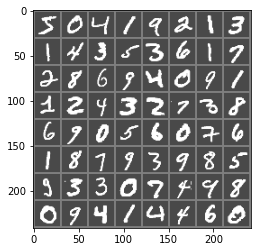

In [6]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Define CNN

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [8]:
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()

# some optimizer options:
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

### Train and test network

In [9]:
def train(model, epochs, train_loader, optimizer, log_interval,  test_loader, save_model, scheduler):
    opt_name = type(optimizer).__name__
    print("Train using {} run at {}".format(opt_name, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    print("\n".join([k+": "+str(v) for (k,v) in locals().items()])) # print info about objective and optimizer
    for epoch in range(epochs):  # loop over the dataset multiple times
        # TRAINING
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward() # compute gradient of the loss wrt parameters
            optimizer.step() # makes an update to its parameters

            # print statistics
            if batch_idx % log_interval == 0:
                print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    opt_name, epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
#                 if dry_run:
#                     break

        # TESTING
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        scheduler.step() #change learning rate

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

### SGD

In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

### SGD Momentum

In [65]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.092899
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.153029
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.454580
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.488214
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.604162
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.466421
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.197068
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.281659
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.675729
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.268295
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.486292
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.200279
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.252504
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.119998
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.205066
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.257970
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.705195
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.254720
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.661099
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.177973
Train Epoch: 0 [12800/60000 (

### SGD Nesterov

In [66]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.021204
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.016966
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.052066
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.044439
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.085274
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.033258
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.006495
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.011712
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.088833
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.016569
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.157390
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.108187
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.010260
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.051963
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.023346
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.023126
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.111943
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.053926
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.020168
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.036005
Train Epoch: 0 [12800/60000 (

### Adagrad

In [67]:
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.008989
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.088366
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.272839
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.193365
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.231595
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.116775
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.007356
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.043019
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.172139
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.091765
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.221102
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.034964
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.201295
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.028103
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.074173
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.031573
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.180666
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.047613
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.119338
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.130913
Train Epoch: 0 [12800/60000 (

### RMSprop

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.044712
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.331156
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.302884
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.291197
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.299835
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.298287
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.302071
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.296621
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.298958
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.290848
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.298798
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.302720
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.308848
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.294562
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.287532
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.301838
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.291644
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.309285
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.293540
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.293900
Train Epoch: 0 [12800/60000 (

### Adam

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train(model, epochs, train_loader, optimizer, log_interval, test_loader, save_model, scheduler)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298005
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.302117
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.307151
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.305822
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.297874
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.298407
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.295198
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.296061
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.297522
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.297006
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.300498
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.301983
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.303872
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.295400
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.290190
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.294917
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.298218
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.300735
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.294785
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.296365
Train Epoch: 0 [12800/60000 (

KeyboardInterrupt: 